In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load the dataset (replace with your actual file path)
#df = pd.read_csv('data/2024-06-01_2024-09-01/aggregated/percent_return.csv')
#df = pd.read_csv('data/2024-08-20_2024-08-28/aggregated/percent_return.csv')
#df = pd.read_csv('data/2023-09-01_2024-09-01/aggregated/percent_return.csv') # 1 year's worth of data
df = pd.read_csv('data/2020-09-01_2024-09-01/aggregated/percent_return.csv')

clustered_df = pd.read_csv('data/Cluster_data/2Clusters(2020-09-01_2024-09-01).csv')

# Extract stock names
stock_names = clustered_df.columns[1:]  # Assuming the first column is the date

# Get companies in Cluster 1, dropping any NaN values
cluster_2_companies = clustered_df['Cluster 2'].dropna().tolist()

# Filter the dataset to include only Cluster 1 companies
df_cluster_2 = df[['date'] + [col for col in df.columns if col in cluster_2_companies]]
df_cluster_2.head(11)
# Print the filtered DataFrame
counter=0
for col in df_cluster_2.columns:
    print(col)
    counter+=1
    print(counter)
df_cluster_2.to_csv("data\cluster_2")
#print(df) #every 5th row is a friday
#print(df) #every 5th row is a friday

date
1
AAPL
2
ABBV
3
ABT
4
ACN
5
ADI
6
ADM
7
ADP
8
AEE
9
AEP
10
AES
11
AFL
12
AIG
13
AIZ
14
AJG
15
ALL
16
ALLE
17
AMAT
18
AMCR
19
AME
20
AMGN
21
AMP
22
AMT
23
AON
24
AOS
25
APA
26
APD
27
APH
28
ARE
29
ATO
30
AVB
31
AVGO
32
AVY
33
AWK
34
AXP
35
BAC
36
BALL
37
BAX
38
BBY
39
BDX
40
BEN
41
BG
42
BK
43
BKR
44
BLK
45
BMY
46
BR
47
BRO
48
BWA
49
BX
50
BXP
51
C
52
CAG
53
CAH
54
CARR
55
CAT
56
CB
57
CBOE
58
CCI
59
CDW
60
CE
61
CF
62
CFG
63
CHD
64
CHRW
65
CI
66
CINF
67
CL
68
CLX
69
CMCSA
70
CME
71
CMI
72
CMS
73
CNP
74
COF
75
COP
76
COR
77
COST
78
CPB
79
CPT
80
CSCO
81
CSX
82
CTAS
83
CTRA
84
CTSH
85
CTVA
86
CVS
87
CVX
88
D
89
DD
90
DE
91
DELL
92
DFS
93
DG
94
DGX
95
DHI
96
DHR
97
DLR
98
DOC
99
DOV
100
DOW
101
DPZ
102
DRI
103
DTE
104
DUK
105
DVN
106
EA
107
EBAY
108
ECL
109
ED
110
EFX
111
EG
112
EIX
113
EL
114
ELV
115
EMN
116
EMR
117
EOG
118
EQIX
119
EQR
120
EQT
121
ERIE
122
ES
123
ESS
124
ETN
125
ETR
126
EVRG
127
EXC
128
EXPD
129
EXR
130
F
131
FANG
132
FAST
133
FCX
134
FDS
135
FDX
136
FE
137
FIS
138

In [3]:
df.shape

(1006, 492)

In [4]:
# Identify companies in Cluster 2 not found in df
missing_companies = [company for company in cluster_2_companies if company not in df.columns]
print(f"Companies in Cluster 2 not found in df: {missing_companies}")
print(f"Number of companies in Cluster 2: {len(cluster_2_companies)}")
print(f"Number of matched companies: {len(cluster_2_companies) - len(missing_companies)}")


Companies in Cluster 2 not found in df: []
Number of companies in Cluster 2: 366
Number of matched companies: 366


In [5]:
# Prepare the data for Monday to Thursday (features) and Friday (target)
X = []
y = []

# Iterate over the dataset in chunks of 5 rows (representing one week)
for i in range(0, len(df_cluster_2), 5):
    if i + 4 >= len(df_cluster_2):  # Prevent going out of bounds
        break
    # Monday to Thursday data (features)
    X.extend(df_cluster_2.iloc[i:i+4, 1:].T.values.tolist()) # rows are companies
    #X += df.iloc[i:i+4, 1:].T.values
    # Friday data (target)
    y.extend(df_cluster_2.iloc[i+4, 1:].T.values.tolist())  # Friday returns as target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np

# Define the parameter distributions
param_dist = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    'gamma': [0, 2, 4, 6, 8, 10],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_delta_step': [0, 2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 1, 2, 5, 10],  # L1 regularization
    'lambda': [1, 2, 4, 6, 8, 10],  # Adjusted L2 regularization
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to sample
    scoring='r2',  # Optimize for R^2 score
    cv=TimeSeriesSplit(n_splits=5),  # 5-fold cross-validation, with time series(stock data)
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train)

# Output best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Retrieve the best model
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)

Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 4, 'max_delta_step': 4, 'learning_rate': 0.02, 'lambda': 1, 'gamma': 2, 'alpha': 1}
Best R^2 Score: 0.8731234281716246


In [7]:
from sklearn.dummy import DummyRegressor

# Baseline model that predicts the mean y for all feature values
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)

In [8]:
# Calculate R^2 scores
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='r2')
print("Cross-Validation Scores (Training Data):", cv_scores)
print("Mean CV R^2 Score:", np.mean(cv_scores))

# Evaluate on test set
test_r2 = r2_score(y_test, best_model.predict(X_test))
print("Test R^2 Score:", test_r2)

baseline_r2 = r2_score(y_test, baseline_predictions) # should be 0, since it predicts the mean
print(f"Baseline R^2 Score: {baseline_r2}")


Cross-Validation Scores (Training Data): [0.86579223 0.8749926  0.87419932 0.87308443 0.87754857]
Mean CV R^2 Score: 0.8731234281716246
Test R^2 Score: 0.8725873259816422
Baseline R^2 Score: -9.91737027988826e-06


In [9]:
### Model evaluation
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse}")

# Calculate RMSE for baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline RMSE:", baseline_rmse)
print("Model Improvement:", baseline_rmse - rmse)

Model RMSE: 1.5929636737295025
Baseline RMSE: 4.462741284473898
Model Improvement: 2.8697776107443955


In [10]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse:.2f}")

# Calculate Baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model Improvement: {baseline_rmse - rmse:.2f}")

# Daily change standard deviation
daily_changes = np.diff(y_test).std()
print(f"Daily Change Std Dev: {daily_changes:.2f}")

# Residuals (errors for each prediction)
residuals = y_test - predictions
print(f"Residuals Std. Dev:{np.std(residuals)}")

Model RMSE: 1.59
Baseline RMSE: 4.46
Model Improvement: 2.87
Daily Change Std Dev: 6.27
Residuals Std. Dev:1.5928911317636243


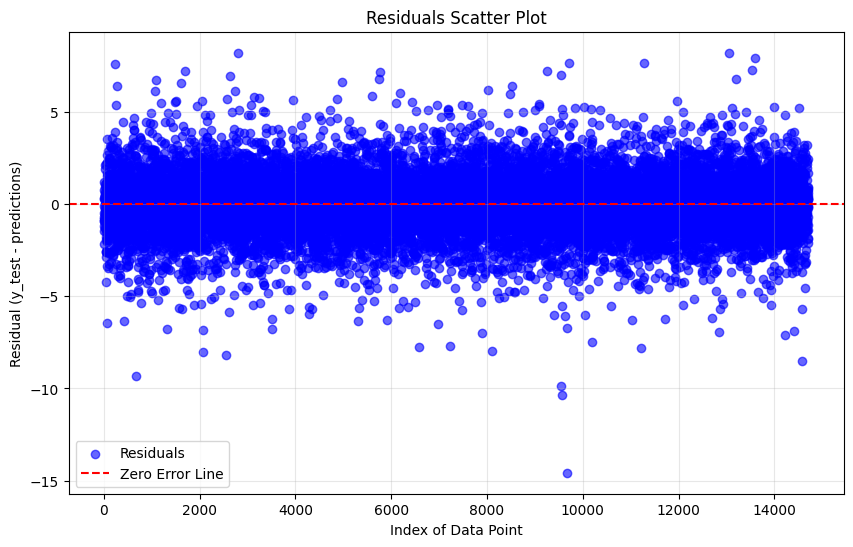

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Residuals (errors for each prediction)
residuals = y_test - predictions

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('Residual (y_test - predictions)')
plt.title('Residuals Scatter Plot')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


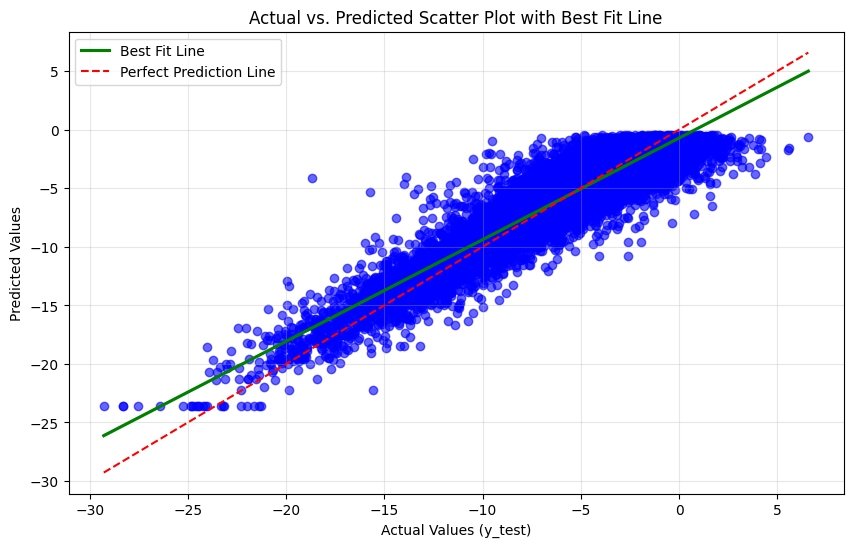

In [12]:
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha': 0.6, 'label': 'Predicted vs. Actual'}, color='blue', line_kws={'color': 'green', 'label': 'Best Fit Line'})

# Add perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')

# Labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Scatter Plot with Best Fit Line')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

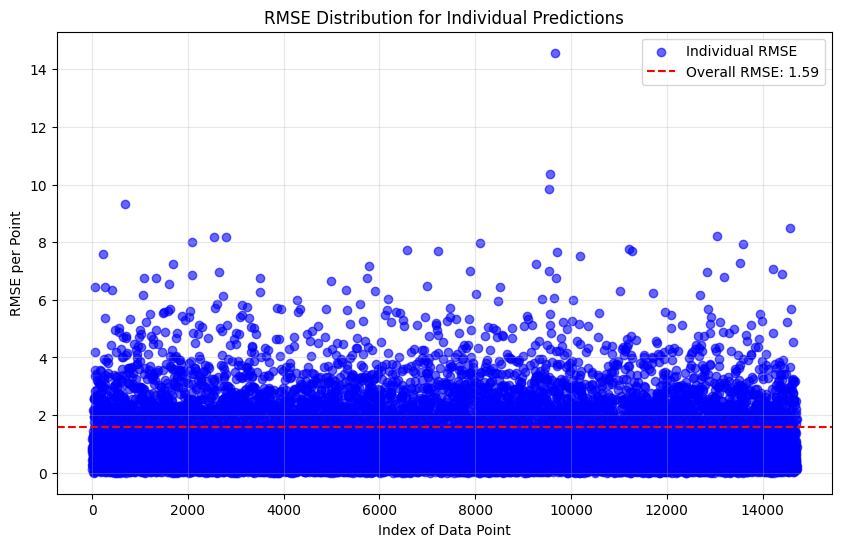

In [13]:
# Calculate individual RMSE values (absolute errors)
individual_rmse = np.sqrt((y_test - predictions) ** 2)

# Scatter plot of individual RMSE values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(individual_rmse)), individual_rmse, alpha=0.6, color='blue', label='Individual RMSE')
plt.axhline(y=rmse, color='red', linestyle='--', label=f'Overall RMSE: {rmse:.2f}')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('RMSE per Point')
plt.title('RMSE Distribution for Individual Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.show()
